# Text Classification using LLMs

In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import  load_dataset
from huggingface_hub import list_datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from huggingface_hub import notebook_login
from torch.nn.functional import cross_entropy

# Subword tokenization

In [7]:
# Subword tokenization
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

encoded_text = tokenizer(text)
print(encoded_text)


{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [8]:
print(encoded_text.input_ids)

[101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102]


In [9]:
# convert ids to token
ids2token = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(ids2token)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [10]:
# Convert token to string
strings = tokenizer.convert_tokens_to_string(ids2token)
print(strings)

[CLS] tokenizing text is a core task of nlp. [SEP]


In [11]:
# Model vocab size
print(tokenizer.vocab_size)

# Model input size (Context size)
print(tokenizer.model_max_length)

# Fields that model expects in its forward pass
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [12]:
all_datasets = list_datasets()


In [13]:
# print(list(all_datasets))

In [14]:
emotions = load_dataset("emotion")

In [15]:
print(emotions)
print("*"*50)
print(emotions["train"])
print("*"*50)
print(emotions["train"].features)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
**************************************************
Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
**************************************************
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [16]:
emotions.set_format(type="pandas")
df = pd.DataFrame(emotions["train"][:])
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [17]:
#get label name
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Check dataset distribution

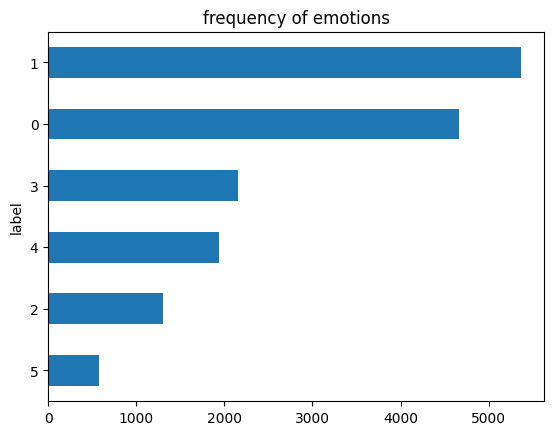

In [18]:
df["label"].value_counts(ascending=True).plot.barh()
plt.title("frequency of emotions")
plt.show()

# Check dataset rows length

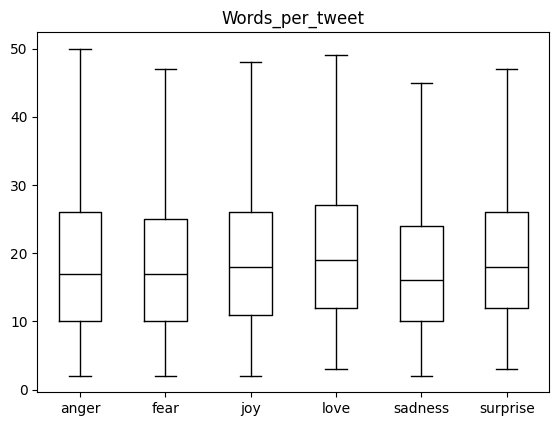

In [19]:
df["Words_per_tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words_per_tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [20]:
# Reset output format of dataset
emotions.reset_format()

# Tokenizing the whole dataset

In [21]:
def tokenize(batch):
    # Padding will pad the examples with zeros to the size of the longest example in the batch
    # truncation will truncate the exmples to the model's maximum context size
    return tokenizer(batch["text"], padding=True, truncation=True)

In [22]:
print(tokenize(emotions["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [23]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [24]:
emotions_encoded['train']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 16000
})

In [25]:
emotions_encoded['train']['input_ids'][0]

[101,
 1045,
 2134,
 2102,
 2514,
 26608,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [27]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

# Feature Extraction and Fine Tuning model to classified
### There are 2 ways to train model to classified based on transformers
1- Feature Extraction
2- Fine-Tunung

## 1- Feature extraction to train a model based on last hidden state layer


In [28]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_states': last_hidden_state[:, 0].cpu().numpy()}

In [29]:
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])
emotion_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

## Create feature matrix for trainig classifier

In [30]:
X_train = np.array(emotion_hidden["train"]["hidden_states"])
X_valid = np.array(emotion_hidden["validation"]["hidden_states"])
y_train = np.array(emotion_hidden["train"]["label"])
y_valid = np.array(emotion_hidden["validation"]["label"])
X_train.shape, X_valid.shape

/tmp/ipykernel_813098/1566292570.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_train = np.array(emotion_hidden["train"]["hidden_states"])
/tmp/ipykernel_813098/1566292570.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_valid = np.array(emotion_hidden["validation"]["hidden_states"])
/tmp/ipykernel_813098/1566292570.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and

((16000, 768), (2000, 768))

In [31]:
# Logistic Regression Classifier
lr_clsf = LogisticRegression(max_iter=1000)
lr_clsf.fit(X_train, y_train)

/home/ubdev2/projects/test/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [32]:
# Classifier score on validation set
lr_clsf.score(X_valid, y_valid)

0.6335

## 2- Fine-Tuning based approach to train a model 


In [33]:
# Loading pretrained model with classification head on top of pre-trained model
labels_count = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=labels_count).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the performance metrics

In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracies = accuracy_score(labels, preds)
    f1_scores = f1_score(labels, preds, average="weighted")
    return {"accuracy": accuracies,"f1_score": f1_scores}

In [35]:
notebook_login()

In [38]:
model_name = f"{model_ckpt}-finetuned-emotions"
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_arguments = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error",
)

In [39]:
trainer = Trainer(
    model=model,
    args=training_arguments,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

trainer.train()

/tmp/ipykernel_813098/2518675090.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/ubdev2/projects/test/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.762000,0.263604,0.920500,0.920690
2,0.211200,0.173114,0.932500,0.932798
3,0.143500,0.164125,0.936500,0.936431


/home/ubdev2/projects/test/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ubdev2/projects/test/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=750, training_loss=0.3722497406005859, metrics={'train_runtime': 5787.4737, 'train_samples_per_second': 8.294, 'train_steps_per_second': 0.13, 'total_flos': 1080514292544000.0, 'train_loss': 0.3722497406005859, 'epoch': 3.0})

In [40]:
predicts = trainer.predict(emotions_encoded["test"])

/home/ubdev2/projects/test/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [41]:
predicts.metrics

{'test_loss': 0.17910239100456238,
 'test_accuracy': 0.921,
 'test_f1_score': 0.9208401090330915,
 'test_runtime': 30.8295,
 'test_samples_per_second': 64.873,
 'test_steps_per_second': 1.038}

## Error Analysis

In [42]:
def error_nalyze(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        outputs = model(**inputs)
        preds_label = torch.argmax(outputs.logits, axis=-1)
        loss = cross_entropy(outputs.logits, batch['label'].to(device), reduction="none")
    return {"loss": loss,"predicted_label": preds_label}

In [43]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded["test"] = emotions_encoded["test"].map(error_nalyze, batched=True, batch_size=32)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [44]:
emotions_encoded["test"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [45]:
print(emotions_encoded['test']['predicted_label'])
print(emotions_encoded['test']['label'])

tensor([0, 0, 0,  ..., 1, 1, 4])
tensor([0, 0, 0,  ..., 1, 1, 4])


In [46]:
cols = ["text", "label", "predicted_label", "loss"]
emotions_encoded.set_format("pandas")
df_test = emotions_encoded["test"][:][cols]
df_test["strlabel"] = df_test['label'].apply(label_int2str)
df_test["strlabel_prediction"] =df_test["predicted_label"].apply(label_int2str)

In [47]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss,strlabel,strlabel_prediction
1382,i cannot even begin to express in words the de...,5,0,7.339678,surprise,sadness
1253,i don t feel betrayed coz the backstabber had ...,5,0,6.966191,surprise,sadness
290,i just feel are ludicrous and wasting space or...,5,0,6.594517,surprise,sadness
816,whenever i put myself in others shoes and try ...,3,1,5.647951,anger,joy
1533,i actually was in a meeting last week where so...,3,0,5.497766,anger,sadness
1928,i feel inside cause life is like a game someti...,4,0,5.167834,fear,sadness
125,i feel very mislead by someone that i really r...,2,3,4.920832,love,anger
1613,i feel very cheated since i am supporting the ...,1,0,4.821317,joy,sadness
1431,i felt a stronger wish to be free from self ch...,0,1,4.580169,sadness,joy
1837,i hate these feelings in my heart i hate that ...,0,3,4.459893,sadness,anger


In [48]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss,strlabel,strlabel_prediction
116,i feel thoroughly virtuous even if the daily t...,1,1,0.006314,joy,joy
1753,i dont know but i feel virtuous so i accept th...,1,1,0.006365,joy,joy
35,i feel more virtuous than when i eat veggies d...,1,1,0.006436,joy,joy
547,i feel a little virtuous doing these things bu...,1,1,0.006479,joy,joy
1831,i feel virtuous and tough when i wear a hat je...,1,1,0.006521,joy,joy
1028,i just feel so virtuous when we go on a fieldtrip,1,1,0.006530,joy,joy
843,i feel more virtuous just looking at the pictu...,1,1,0.006645,joy,joy
1915,i like being in church on sundays it makes me ...,1,1,0.006782,joy,joy
186,i don t like eating meals that feel too virtuous,1,1,0.006838,joy,joy
1128,i seem to share an equal passion for long dist...,1,1,0.006896,joy,joy


# Save and Share the model

In [ ]:
# trainer.save_model('distilbert-base-uncased-finetuned-emotions/best_model/')

In [49]:
trainer.push_to_hub(commit_message="Training Completed")

CommitInfo(commit_url='https://huggingface.co/SiamakParhizkari/distilbert-base-uncased-finetuned-emotions/commit/5d84203128fcb3981b417dd79ccd2e10e1c26711', commit_message='Training Completed', commit_description='', oid='5d84203128fcb3981b417dd79ccd2e10e1c26711', pr_url=None, repo_url=RepoUrl('https://huggingface.co/SiamakParhizkari/distilbert-base-uncased-finetuned-emotions', endpoint='https://huggingface.co', repo_type='model', repo_id='SiamakParhizkari/distilbert-base-uncased-finetuned-emotions'), pr_revision=None, pr_num=None)